# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. **Постройте модель машинного обучения**, которая поможет определить регион, где добыча принесёт наибольшую прибыль. **Проанализируйте** возможную **прибыль** и **риски** техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка бибилиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from  sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [2]:
!pip install phik -q
from phik import phik_matrix
from phik.report import plot_correlation_matrix

Библиотеки загружены без ошибок

### Загрузка датасетов

Регион 1

In [3]:
df_rg1 = pd.read_csv('/datasets/geo_data_0.csv', sep=',', decimal='.')
df_rg1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Регион 2

In [4]:
df_rg2 = pd.read_csv('/datasets/geo_data_1.csv', decimal='.', sep=',')
df_rg2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Регион 3

In [5]:
df_rg3 = pd.read_csv('/datasets/geo_data_2.csv', decimal='.', sep=',')
df_rg3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Датафреймы загружены без ошибок и соответсвуют теми исследования

### Проверка на пропуски и типы данных

Словарь с датафреймами для удобства перебора

In [6]:
df_dict = {'df_rg1':df_rg1, 'df_rg2':df_rg2, 'df_rg3':df_rg3}

Перебор всех датафреймов в цикле

In [7]:
for name, df in df_dict.items():
    print(name)
    print('-------------------------------------')
    print(df.info(), end='\n\n')

df_rg1
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

df_rg2
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

df_rg3
-----------------------

Проблем с пропусками и типами данных нет

### Проверка на явные и неявные дубликаты

Переберем датафреймы, чтобы проверить наличие явных дубликатов в строках без id

In [8]:
for name, df in df_dict.items():
    print(f'Датафрейм {name}, к-во дубликатов строк', end=': ')
    print(df.drop('id',axis=1).duplicated().sum(), end='\n\n')

Датафрейм df_rg1, к-во дубликатов строк: 0

Датафрейм df_rg2, к-во дубликатов строк: 0

Датафрейм df_rg3, к-во дубликатов строк: 0



Проверка признака id на наличие дубликатов в датафрейме через цикл

In [9]:
for name, df in df_dict.items():
    print(f'К-во повторяющихся id в {name}: ', df['id'].duplicated().sum(), end='\n\n')

К-во повторяющихся id в df_rg1:  10

К-во повторяющихся id в df_rg2:  4

К-во повторяющихся id в df_rg3:  4



Устранение дубликатов в признаке id с оставлением первого повторяющегося в датафреймах через цикл с проверкой успешности результата

In [10]:
for name, df in df_dict.items():
    df_dict[name] = df.drop_duplicates(subset=['id'], keep='first')
    print(f'К-во повторяющихся id в {name}: ',df_dict[name]['id'].duplicated().sum(), end='\n\n')

К-во повторяющихся id в df_rg1:  0

К-во повторяющихся id в df_rg2:  0

К-во повторяющихся id в df_rg3:  0



Проверка текущего размера датафреймов относительно первоначального размера

In [11]:
for name, df in df_dict.items():
    print(f'Текущий размер {name}: ',df.shape[0])

Текущий размер df_rg1:  99990
Текущий размер df_rg2:  99996
Текущий размер df_rg3:  99996


* Дубликатов среди строк не выявлено
* Дубликаты среди id выявлены и устранены

### Корреляционный анализ

Для выявления мультиколлинеарности проведем корреляционный анализ признаков датафрейма

Выпишем названия всех столбцов непрерывных количественных велечин

In [19]:
interval_columns = df_dict['df_rg1'].select_dtypes(exclude=['object']).columns
interval_columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Построим матрицы корреляции для всех признаков каждого датафрейма

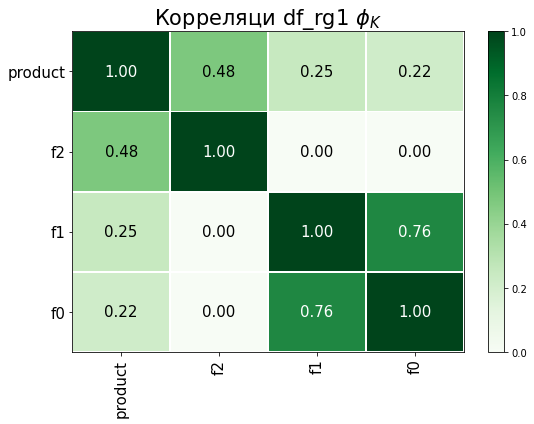

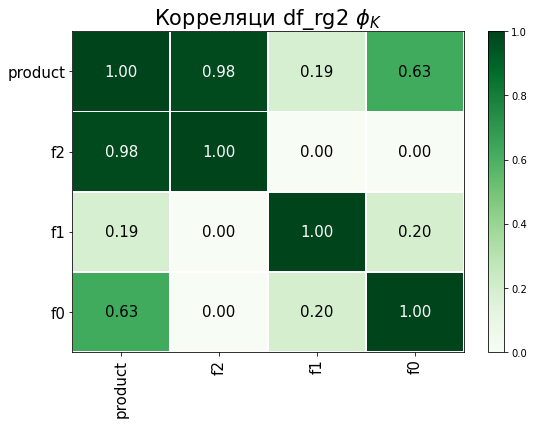

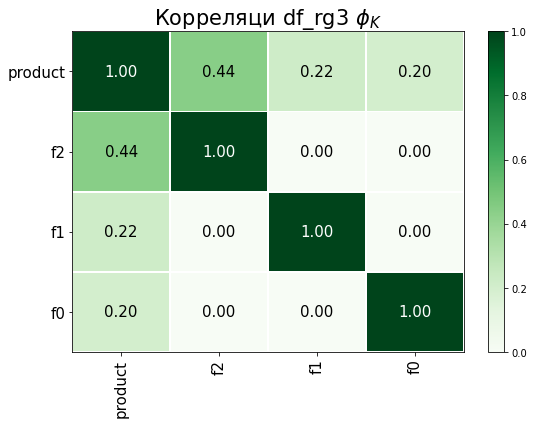

In [20]:
for name, df in df_dict.items():
    phik_over_view = phik_matrix(df.drop('id', axis=1), interval_cols=interval_columns)
    plot_correlation_matrix(
        phik_over_view.values,
        x_labels=phik_over_view.columns,
        y_labels=phik_over_view.index,
        vmin=0,vmax=1,color_map='Greens',
        title=f'Корреляци {name} $\phi_K$',
        fontsize_factor=1.5,
        figsize=(8,6)
    )

Во втором датафрейме присутвует мультиколлиниарность

### Вывод

* Библиотеки загружены без ошибок
* Датафремы загружены без ошибок и соответсвуют теме исследования
* Пропуски и проблемы с типами данных отсутствуют
* Явные дубликаты отсутствуют
* Неявные дубликаты устранены
* Выбросы обнаружены и устранены
* При обучении моделей для датафрейма Региона 2 следует использовать методы регуляризации для нивелирования мультиколлинеарности
* В виду того, что не известно значение признаков, исследовательский анализ данных считаю применять не целесообразным

## Обучение и проверка модели

### Подготовка пайплайнов

Названия признаков в датафреймах

In [21]:
num_columns = ['f0', 'f1', 'f2']

Константа случайного значения

In [22]:
RANDOM_STATE = 42

Пайплайн нормирования числовых признаков, а также пайплайн предобработки и обучения модели

In [23]:
data_preprocessor = ColumnTransformer(
    [
        ('num',
         'passthrough', num_columns
        )
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline(
    [
        (
            'preprocessor',
            data_preprocessor
        ),
        (
            'models',
            DummyRegressor()
        )
    ]
)

### Гиперпараметры

Здесь представленна дамми модель, которая выдает случайный результат, модель линейной регрессии, а также модель линейной регрессии с регуляризацией l1 и l2

In [24]:
param_grid = [
    #LinearRegression with l1 and l2
    {
        'models':[ElasticNet(random_state=RANDOM_STATE)],
        'preprocessor__num':[StandardScaler(),'passthrough'],
        'models__alpha':[1, 0.5, 0.1],
        'models__l1_ratio':[0.1, 0.5, 0.9],
    },
    
    #LinearRegression
    {
        'models':[LinearRegression()],
        'preprocessor__num':[StandardScaler(), 'passthrough'],
    },
    
    #DummyRegressor
    {
        'models': [DummyRegressor()]
    }
    
]

### Подготовка данных

Будем хранить все данные о регионах в одном словаре

In [25]:
data_dict = {}

Разделим данные для каждого региона на тренировочные и валидационные выборки, сбросим индексы валидационной выборки для дальнейшего удобства использования, а также подготовимся к перебору гиперпараметров

In [26]:
for name, df in df_dict.items():
    data_dict[name] = {'full': df, 'X_train': None, 'y_train': None, 'X_test': None, 'y_test': None, 'grid_search': None}
    
    X = df.drop(['product'], axis=1)
    y = df['product']
    
    data_dict[name]['X_train'], data_dict[name]['X_valid'], data_dict[name]['y_train'], data_dict[name]['y_valid'] = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    data_dict[name]['X_valid'] = data_dict[name]['X_valid'].reset_index(drop=True)
    data_dict[name]['y_valid'] = data_dict[name]['y_valid'].reset_index(drop=True)
    
    data_dict[name]['grid_search'] = GridSearchCV(
        pipe_final, 
        param_grid=param_grid, 
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

### Обучение моделей

In [27]:
for name in data_dict.keys():
    data_dict[name]['grid_search'].fit(data_dict[name]['X_train'].drop(['id'],axis=1), data_dict[name]['y_train'])
    data_dict[name]['y_valid_pred'] = data_dict[name]['grid_search'].best_estimator_.predict(data_dict[name]['X_valid'].drop(['id'],axis=1))
    data_dict[name]['y_valid_pred'] = pd.DataFrame(data_dict[name]['y_valid_pred'], columns=['product_pred'])

### Результаты обучения моделей

In [28]:
for name in data_dict.keys():
    result = pd.DataFrame(data_dict[name]['grid_search'].cv_results_)
    print(f'Рейтинг моделей для датасета {name} на тренировочной выборке по метрике RMSE:')
    print(result[
        ['rank_test_score', 'param_models', 'mean_test_score']
    ].sort_values('rank_test_score')[['param_models', 'mean_test_score']].head(21))
    print(f'\nПараметры лучшей модели:')
    for key, param in result.sort_values('rank_test_score').head(1).reset_index(drop=True)[['params']].loc[0, 'params'].items():
        print(f'• {key}: {param}')
    print(f'\nRMSE на валидационной выборке датасета {name}: ', mean_squared_error(np.array(data_dict[name]['y_valid']), np.array(data_dict[name]['y_valid_pred']), squared=False))
    print(f'\nСредний запас предсказанного сырья  датасета {name}:', data_dict[name]['y_valid_pred']['product_pred'].mean(), end='\n')
    print(f'\nСредний запас реального сырья  датасета {name}:', data_dict[name]['y_valid'].mean(), end='\n')
    print('------------------------------------------------------------------------------\n')

Рейтинг моделей для датасета df_rg1 на тренировочной выборке по метрике RMSE:
                                         param_models  mean_test_score
18                                 LinearRegression()       -37.696867
19                                 LinearRegression()       -37.696867
16  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.698408
17  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.699409
14  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.713801
15  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.717769
10  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.733445
13  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.742948
12  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.743197
11  ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.745494
4   ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.831164
5   ElasticNet(alpha=0.5, l1_ratio=0.9, random_sta...       -37.842373

### Вывод

* Линейная регрессия плохо справляется с прогнозами в регионе 1 и 3
* В регионе 2 мультиколлинеарность удается победить с помощью регуляризации, однако исходная модель справляется лучше и при том без потери точности на валидационной выборке
* Средний предсказанный запас сырья и средний реальный очень близки по значению

## Подготовка к расчёту прибыли

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Сохранение ключевых значений для расчета прибыли

In [29]:
NUM_POINTS = 500
BEST_POINTS = 200
BUDGET = 10_000_000_000
INCOME_PER_UNIT = 450000
PROBABILITY_OF_LOSS = 0.025

###  Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравение полученных объёмов сырья со средним запасом в каждом регионе.

In [30]:
sufficient_amount = BUDGET / BEST_POINTS / INCOME_PER_UNIT
print('Объёма сырья для безубыточной разработки новой скважины:',round(sufficient_amount))

Объёма сырья для безубыточной разработки новой скважины: 111


In [31]:
for name in data_dict.keys():
    print(f'Средний запас предсказанного сырья  датасета {name}:', round(data_dict[name]['y_valid_pred']['product_pred'].mean()), end='\n')

Средний запас предсказанного сырья  датасета df_rg1: 93
Средний запас предсказанного сырья  датасета df_rg2: 69
Средний запас предсказанного сырья  датасета df_rg3: 95


### Вывод

* Средний объем сырья для безубыточной разработки новой скважины превышает фактически предсказанный средний объем, однако при уточнении количества скважин в пользу лучших, я уверен, что проблема будет устранена

## Расчёт прибыли и рисков 

Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [32]:
def profit_calculation(points_true, points_pred, count_points=BEST_POINTS, budget=BUDGET, income=INCOME_PER_UNIT):
    
    index_of_true_points = points_pred.reset_index(drop=True).sort_values(ascending=False)[:count_points].index
    sum_production = points_true.reset_index(drop=True)[index_of_true_points].sum()
    revenue = sum_production * income
    
    return round((revenue - budget))

Расчет фактической максимальной прибыли для каждого региона

In [33]:
for name in data_dict.keys():
    total_income = profit_calculation(data_dict[name]['y_valid'],data_dict[name]['y_valid_pred']['product_pred'])
    print(f'Прибыль для региона {name} по 200 лучшим точкам :', end=' ')
    print(f'{total_income} р.')

Прибыль для региона df_rg1 по 200 лучшим точкам : 3468529787 р.
Прибыль для региона df_rg2 по 200 лучшим точкам : 2415086697 р.
Прибыль для региона df_rg3 по 200 лучшим точкам : 2448027879 р.


Функция применения техники bootstrap для оценки средней прибыли, 95%-й доверительного интервала и риска убытков

In [34]:
def bootstrap_check(points_true, points_pred, n=NUM_POINTS):
    rs = np.random.RandomState(12345)
    values = []
    
    for i in range(0,1000):
        
        subsample_pred = points_pred.sample(n=n, replace=True, random_state=rs)
        subsample_true = points_true[subsample_pred.index]
        
        values.append(profit_calculation(subsample_true, subsample_pred))
    
    values = pd.Series(values)
    print('Средняя прибыль, р.: ', round(values.mean()))
    print('95%-й доверительный интервал, р.: [', round(values.quantile(0.025)), ', ', round(values.quantile(0.975)), ']', sep='')        
    print('Риск убытков, %: ', round((values < 0).mean() * 100, 2))

Применение функции bootstrap_check ко всем регионам в цикле.

In [35]:
for name in data_dict.keys():
    print(f'Техника  bootstrap для датафрейма {name}.')
    bootstrap_check(data_dict[name]['y_valid'], data_dict[name]['y_valid_pred']['product_pred'])
    print('----------------------------------------------------------------------\n')

Техника  bootstrap для датафрейма df_rg1.
Средняя прибыль, р.:  417354353
95%-й доверительный интервал, р.: [-96261928, 933493096]
Риск убытков, %:  5.9
----------------------------------------------------------------------

Техника  bootstrap для датафрейма df_rg2.
Средняя прибыль, р.:  432017870
95%-й доверительный интервал, р.: [51741836, 863042250]
Риск убытков, %:  1.0
----------------------------------------------------------------------

Техника  bootstrap для датафрейма df_rg3.
Средняя прибыль, р.:  356229805
95%-й доверительный интервал, р.: [-183478898, 879977424]
Риск убытков, %:  8.5
----------------------------------------------------------------------



### Вывод

* Для разработки скважин предлагаю регион 2, так как риск убытков по условию меньше 2.5 % а также, потому что среняя ожидаемая прибыль самая высокая среди перечисленных регионов
* Регион 1 и 3 имеют риск превышающий допустимый